# Customer Segmentation

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
print("Setup Complete")

Setup Complete


In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

In [3]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## Data Cleaning


__Attributes__:

People
- `ID`: Customer's unique identifier
- `Year_Birth`: Customer's birth year
- `Education`: Customer's education level
- `Marital_Status`: Customer's marital status
- `Income`: Customer's yearly household income
- `Kidhome`: Number of children in customer's household
- `Teenhome`: Number of teenagers in customer's household
- `Dt_Customer`: Date of customer's enrollment with the company
- `Recency`: Number of days since customer's last purchase
- `Complain`: 1 if the customer complained in the last 2 years, 0 otherwise

Products

- `MntWines`: Amount spent on wine in last 2 years
- `MntFruits`: Amount spent on fruits in last 2 years
- `MntMeatProducts`: Amount spent on meat in last 2 years
- `MntFishProducts`: Amount spent on fish in last 2 years
- `MntSweetProducts`: Amount spent on sweets in last 2 years
- `MntGoldProds`: Amount spent on gold in last 2 years

Promotion

- `NumDealsPurchases`: Number of purchases made with a discount
- `AcceptedCmp1`: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- `AcceptedCmp2`: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- `AcceptedCmp3`: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- `AcceptedCmp4`: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- `AcceptedCmp5`: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- `Response`: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

- `NumWebPurchases`: Number of purchases made through the company’s website
- `NumCatalogPurchases`: Number of purchases made using a catalogue
- `NumStorePurchases`: Number of purchases made directly in stores
- `NumWebVisitsMonth`: Number of visits to company’s website in the last month


In [4]:
print('Number of missing entries:', pd.isnull(df).sum().sum())
# Drop rows with missing entries
df = df.dropna()

Number of missing entries: 24


It appears as if `Z_CostContact` and `Z_Revenue` all have values equal to zero, so we will drop these columns

In [5]:
df = df.drop(['Z_CostContact', 'Z_Revenue'], axis=1)

### Categorical Data

In [6]:
print('Categorical/String Columns:')
df.dtypes[df.dtypes == 'object']

Categorical/String Columns:


Education         object
Marital_Status    object
Dt_Customer       object
dtype: object

In [7]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [8]:
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
# drop absurd and yolo
df = df.drop(df.index[df['Marital_Status'] == 'Absurd'], axis=0)
df = df.drop(df.index[df['Marital_Status'] == 'YOLO'], axis=0)

It is unclear what absurd and YOLO mean, so we can drop them

Now we shall investigate education level

In [9]:
df['Education'].value_counts()

Graduation    1115
PhD            479
Master         364
2n Cycle       200
Basic           54
Name: Education, dtype: int64

### Numerical Data

What is the range of dates the customers registered?

In [10]:
df['Dt_Customer'] = df['Dt_Customer'].astype('datetime64')
print('Latest dt registered:', df['Dt_Customer'].max())
print('Earliest dt registered:', df['Dt_Customer'].min())

Latest dt registered: 2014-12-06 00:00:00
Earliest dt registered: 2012-01-08 00:00:00


C:\Users\Claudeon\AppData\Local\Temp\ipykernel_32184\325786078.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = df['Dt_Customer'].astype('datetime64')


In [11]:
latest_reg = df['Dt_Customer'].max()
print('Latest year:', latest_reg.year)

Latest year: 2014


In [12]:
df['Days_Registered'] = pd.to_numeric(latest_reg-df['Dt_Customer'])
df = df.drop('Dt_Customer', axis=1)

We also need to convert customer birth year to current age at the time of recording

In [13]:
df['Age'] = -(df['Year_Birth']) + latest_reg.year
df = df.drop('Year_Birth', axis=1)

To get a bigger picture of the number of children

In [14]:
df['Children'] = df['Kidhome'] + df['Teenhome']

Is the customer is living alone or not?

In [15]:
def is_alone(status):
    if status in ('Married', 'Together'):
        return 0;
    else:
        return 1;
df['Is_Alone'] = df['Marital_Status'].apply(is_alone)
df = df.drop('Marital_Status', axis=1)

Education Status

In [16]:
df["Education"]=df["Education"].replace({
    "Basic":"Undergraduate",
    "2n Cycle":"Undergraduate", 
    "Graduation":"Graduate", 
    "Master":"Postgraduate", 
    "PhD":"Postgraduate"
    })

In [17]:
df = df.drop('ID', axis=1)

In [18]:
df

Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0         Graduate  58138.0        0         0       58       635         88   
1         Graduate  46344.0        1         1       38        11          1   
2         Graduate  71613.0        0         0       26       426         49   
3         Graduate  26646.0        1         0       26        11          4   
4     Postgraduate  58293.0        1         0       94       173         43   
...            ...      ...      ...       ...      ...       ...        ...   
2235      Graduate  61223.0        0         1       46       709         43   
2236  Postgraduate  64014.0        2         1       56       406          0   
2237      Graduate  56981.0        0         0       91       908         48   
2238  Postgraduate  69245.0        0         1        8       428         30   
2239  Postgraduate  52869.0        1         1       40        84          3   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  AcceptedCmp4  \
0                 546              172                88  ...             0   
1                   6                2                 1  ...             0   
2                 127              111                21  ...             0   
3                  20               10                 3  ...             0   
4                 118               46                27  ...             0   
...               ...              ...               ...  ...           ...   
2235              182               42               118  ...             0   
2236               30                0                 0  ...             0   
2237              217               32                12  ...             1   
2238              214               80                30  ...             0   
2239               61                2                 1  ...             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0                0             0             0         0         1   
1                0             0             0         0         0   
2                0             0             0         0         0   
3                0             0             0         0         0   
4                0             0             0         0         0   
...            ...           ...           ...       ...       ...   
2235             0             0             0         0         0   
2236             0             1             0         0         0   
2237             0             0             0         0         0   
2238             0             0             0         0         0   
2239             0             0             0         0         1   

        Days_Registered  Age  Children  Is_Alone  
0     83894400000000000   57         0         1  
1     10800000000000000   60         2         1  
2     40780800000000000   49         0         0  
3      5616000000000000   30         1         0  
4     27734400000000000   33         1         0  
...                 ...  ...       ...       ...  
2235  46742400000000000   47         1         0  
2236   5270400000000000   68         3         0  
2237  27216000000000000   33         0         1  
2238  27302400000000000   58         1         0  
2239  67564800000000000   60         2         0  

[2212 rows x 27 columns]

### Feature Engineering (Marketing)
In this section we will be adding some features, most notably:

* `MntTotal`: total amount spent
* `NumTotalPurchases`: total number of purchases made
* `PctDealsPurchases`: percentage of purchases made with discount

In [19]:
# Total Amount spent
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Total number of purchases
df['NumTotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Percentage of purchases made with discount
df['PctDealsPurchases'] = df['NumDealsPurchases']/df['NumTotalPurchases']

## Data Visualization

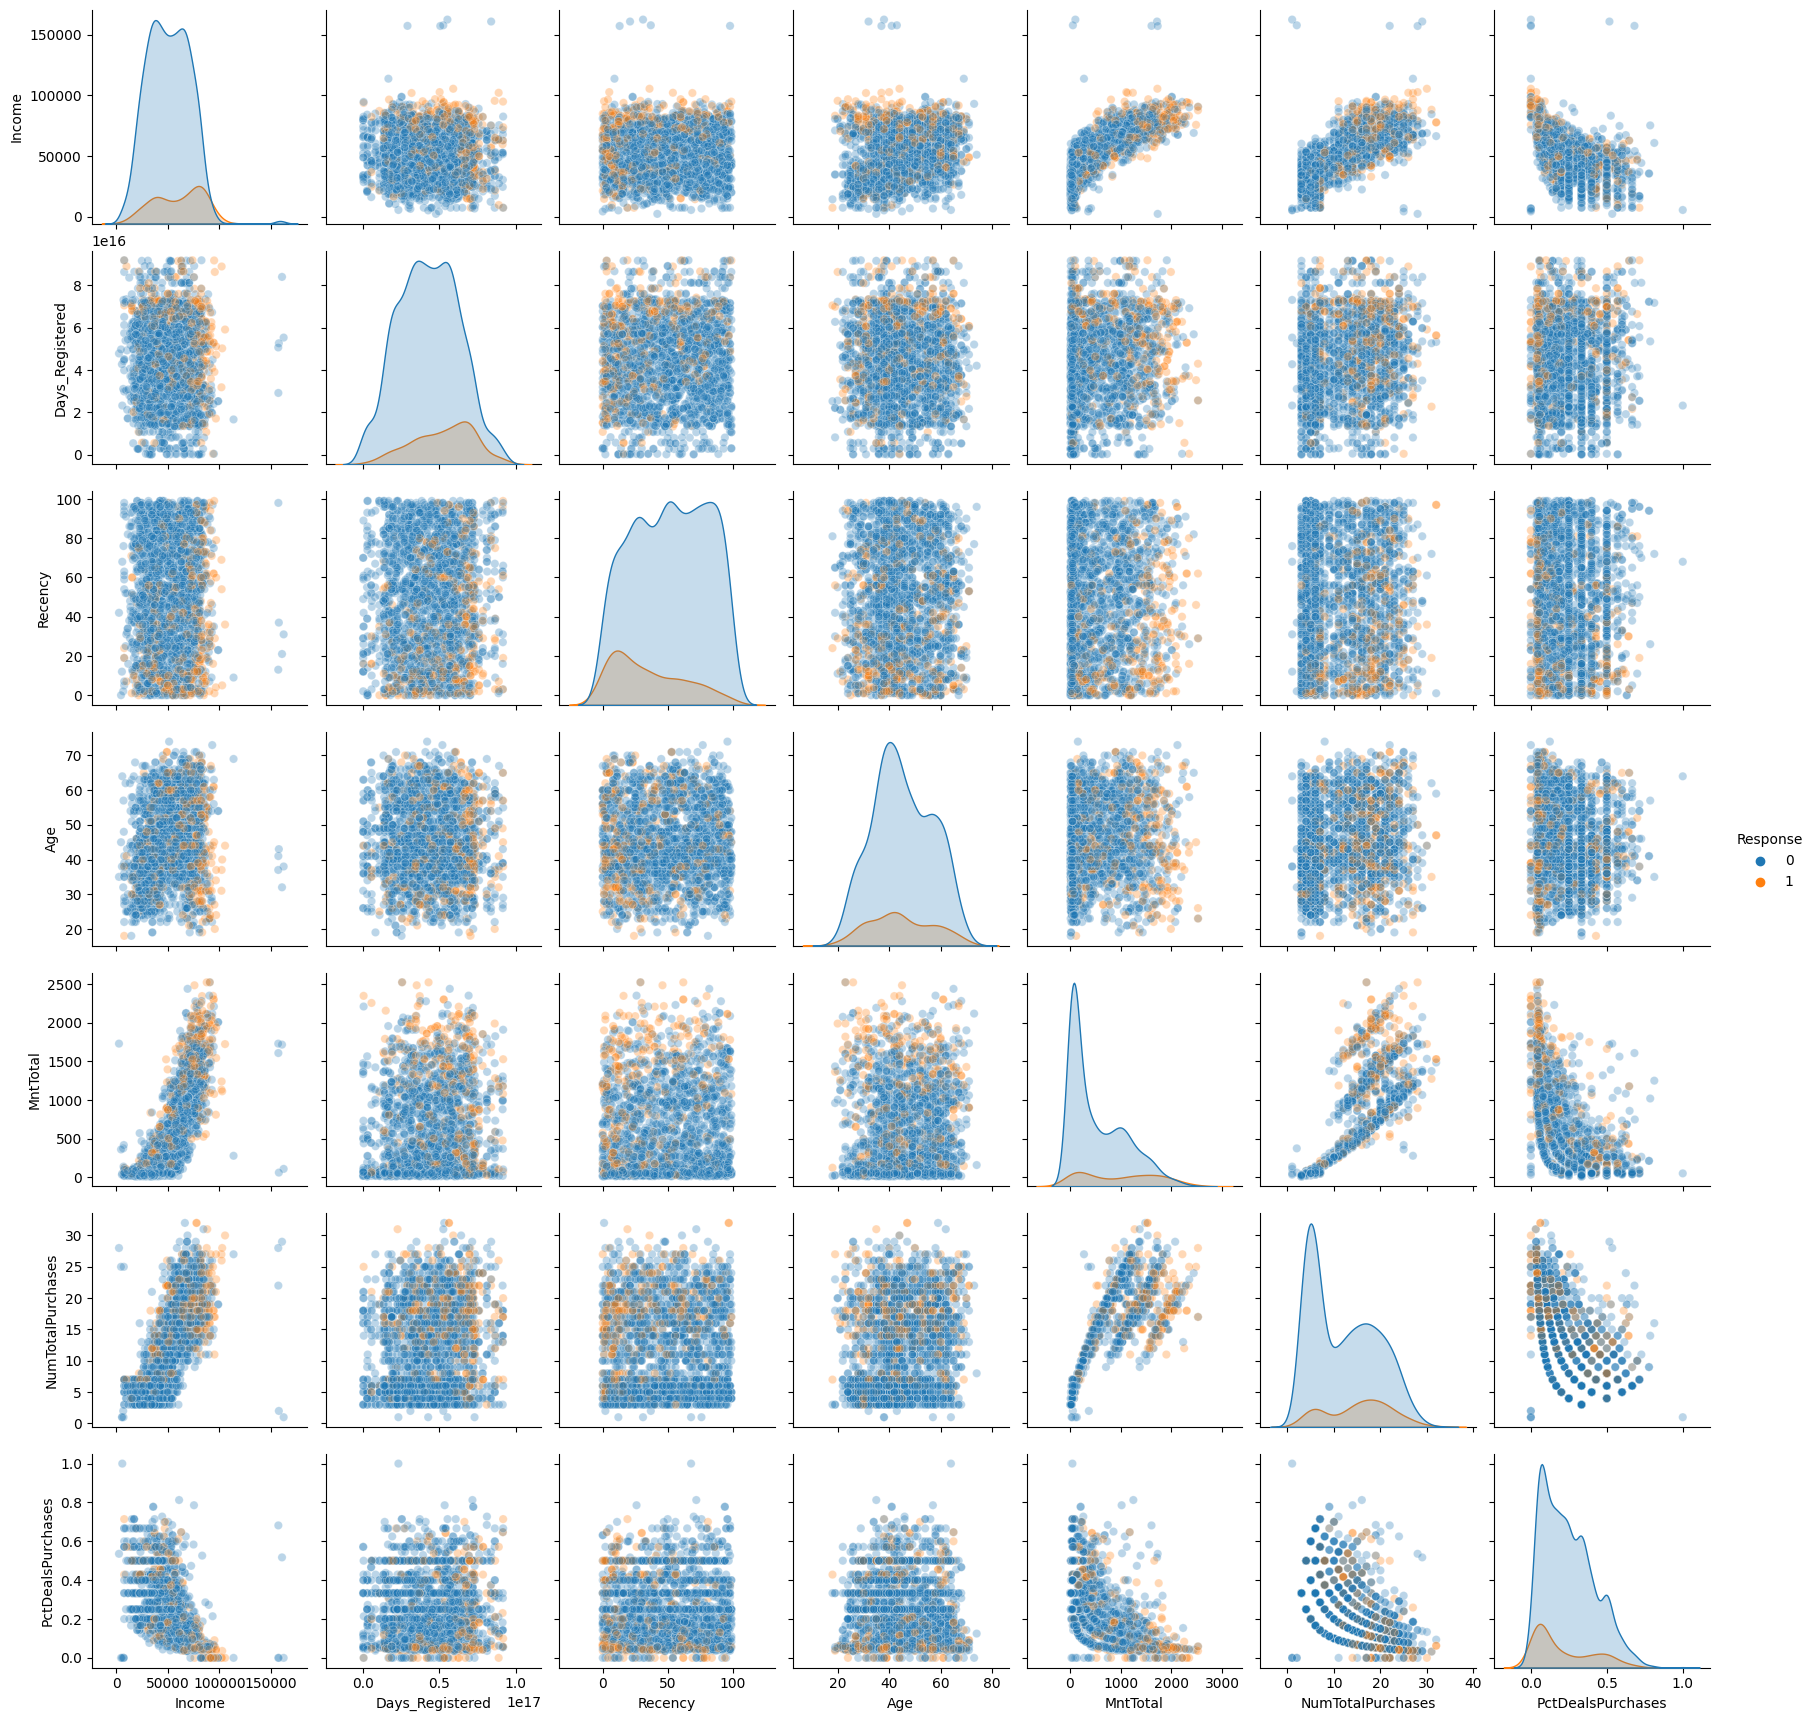

In [98]:
to_plot = ['Education', 'Income', 'Days_Registered', 'Recency', 'Age', 'MntTotal', 'NumTotalPurchases', 'PctDealsPurchases', 'Response']
sns.pairplot(df[to_plot], hue='Response',plot_kws={'alpha':0.3})

We will remove outliers:

* Age > 100
* PctDealsPurchases > 10.0
* Income > 200,000

In [81]:
df = df[df['Age'] <= 100]
df = df[df['PctDealsPurchases'] <= 10]
df = df[df['Income'] <= 200000]

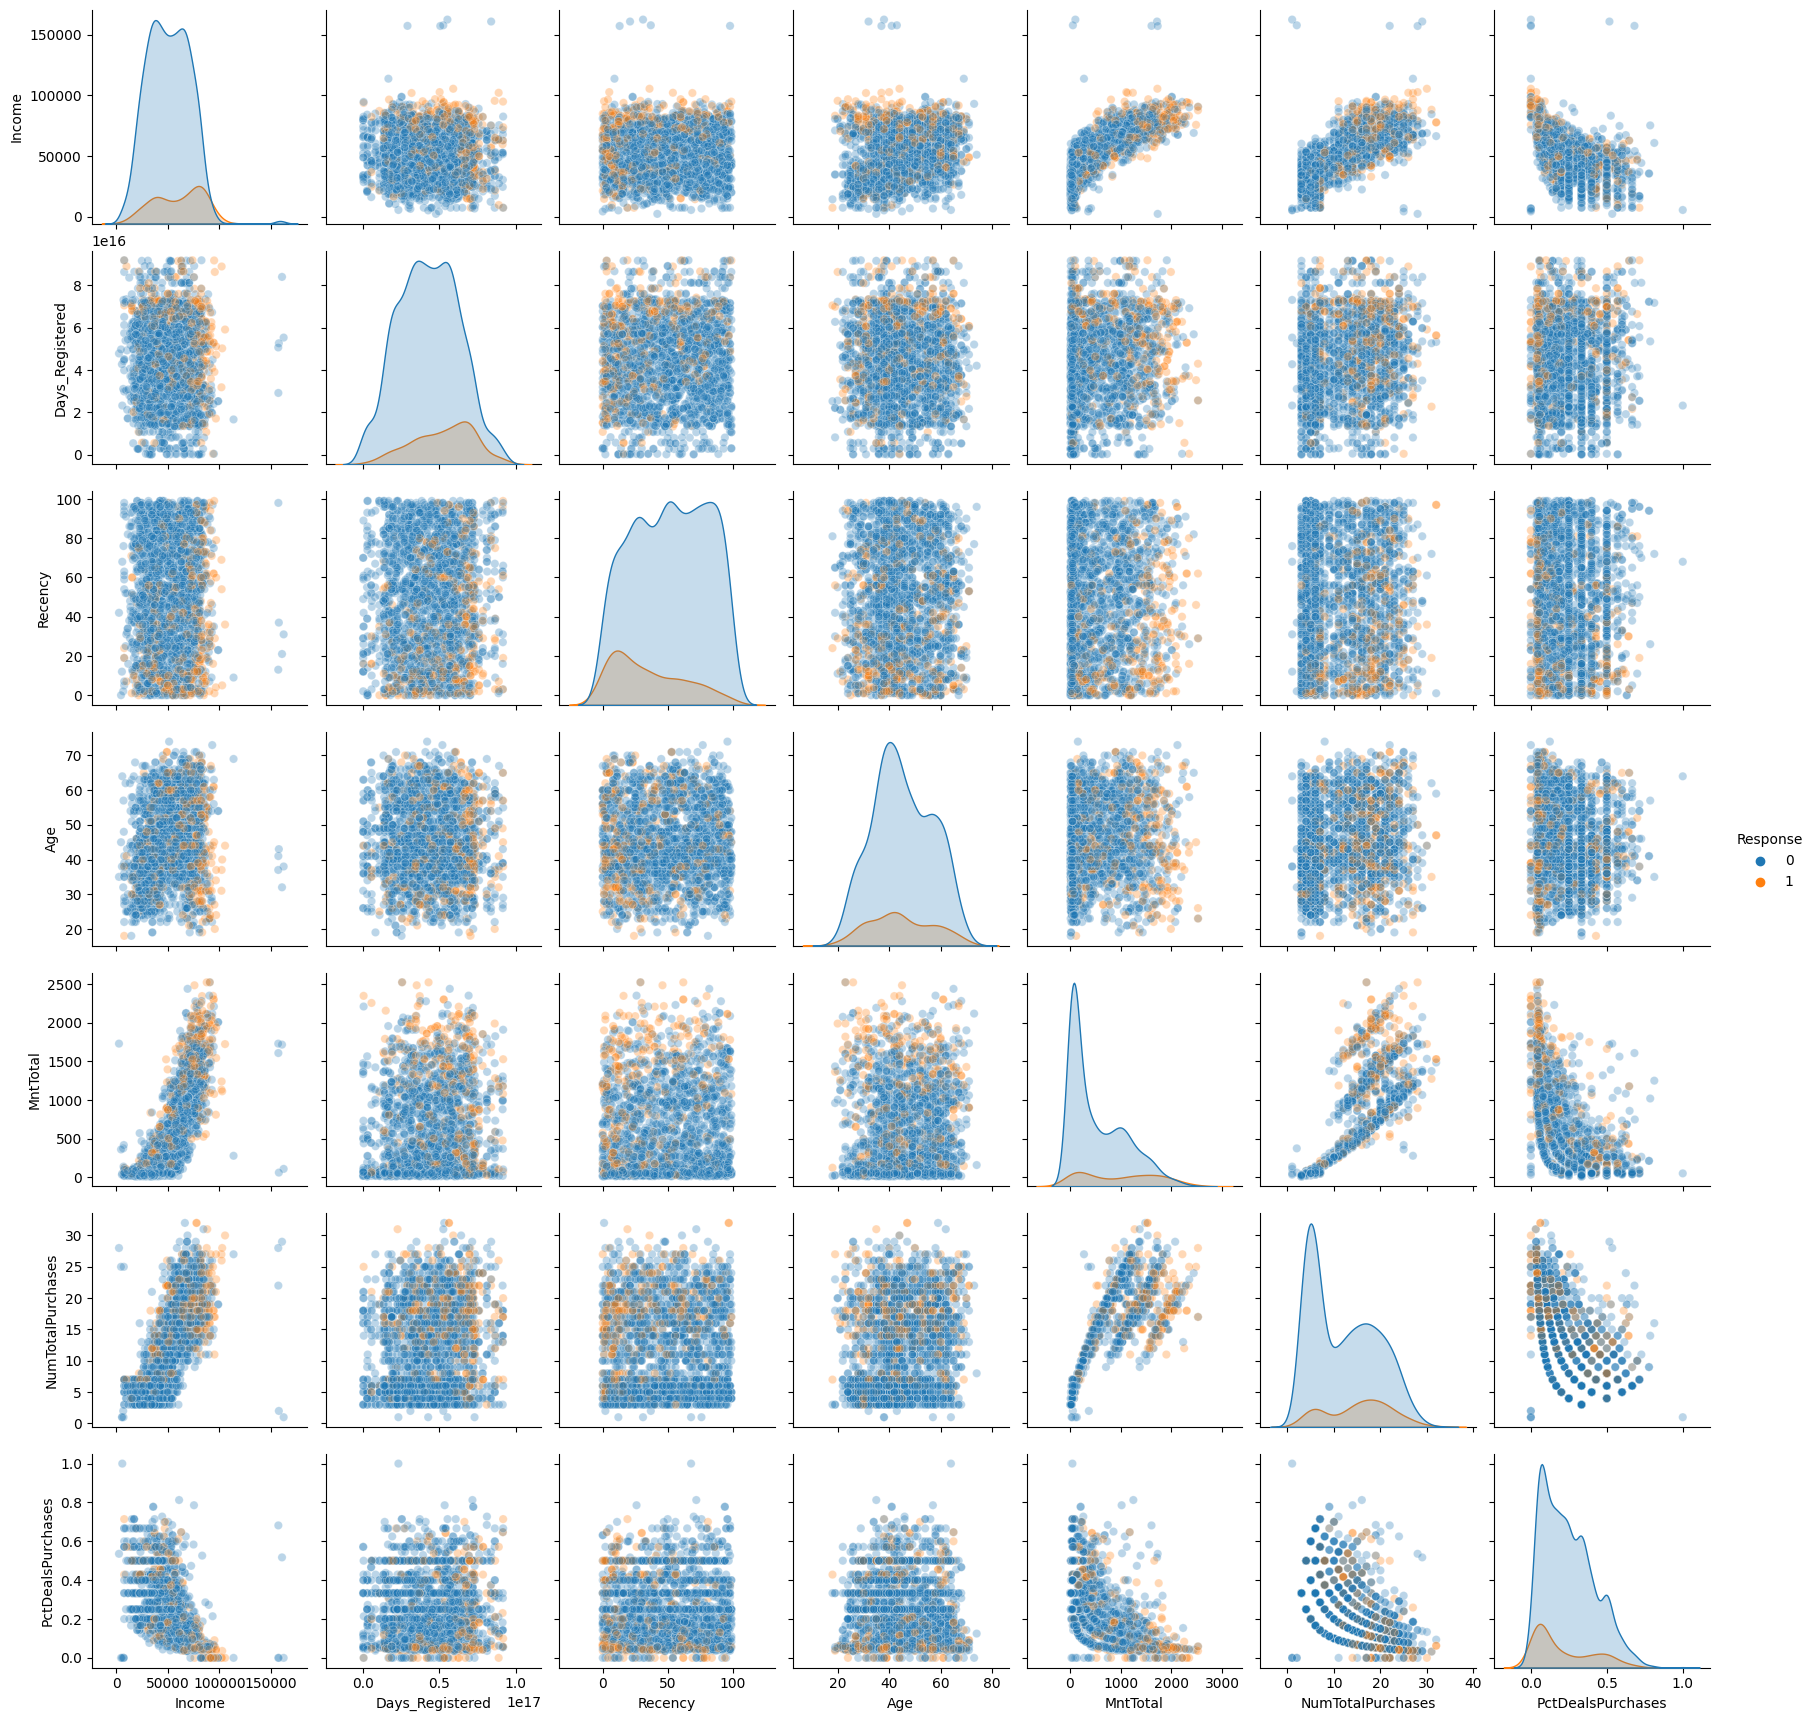

In [110]:
sns.pairplot(df[to_plot], hue='Response',plot_kws={'alpha':0.3})

It seems that there is positive correlation between total amount spent and income, as well as between number of purchases and income which is to be expected

There is also negative correlation between income and proportion of purchases with deals (that is as income increases, customers are less likely to purchase with deals) which is also expected

The relationship between total number of purchases and percentage of purchases purchased using deals is also interesting

<AxesSubplot: xlabel='Income', ylabel='Count'>

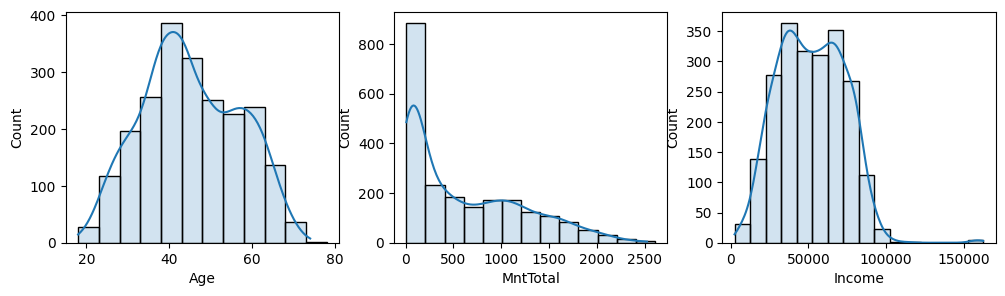

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
sns.histplot(df, x='Age',kde=True, binwidth=5, alpha=0.2, ax=ax[0])
sns.histplot(df['MntTotal'], kde=True, binwidth=200, alpha=0.2, ax=ax[1])
sns.histplot(df['Income'], kde=True, binwidth=10000, alpha=0.2, ax=ax[2])

In [70]:
print('Percentage of customers with age 30-50:', ((df['Age'] <= 50).sum() - (df['Age'] <= 30).sum())/df.shape[0]*100)

Percentage of customers with age 30-50: 55.36441828881847


We can see that the majority of customers are around the age of 30-50, with most customers in their 40s

Furthermore, most customers spend $0-$200 in total

## K-Means Clustering

### Clustering based on total number of purchases and total amount spent

For this section, we will cluster the customers into three groups, which is partly inspired by the scatterplot below which shows three different lines (groups) of customers with different average amount spent

In [136]:
temp_df = df.drop(['Education'], axis=1)
temp_df['Education_Ordinal'] = df['Education'].replace({'Undergraduate': 1, 'Graduate':2, 'Postgraduate':3})
num_cols = temp_df.columns

Text(0.5, 1.0, 'Correlation between Variables')

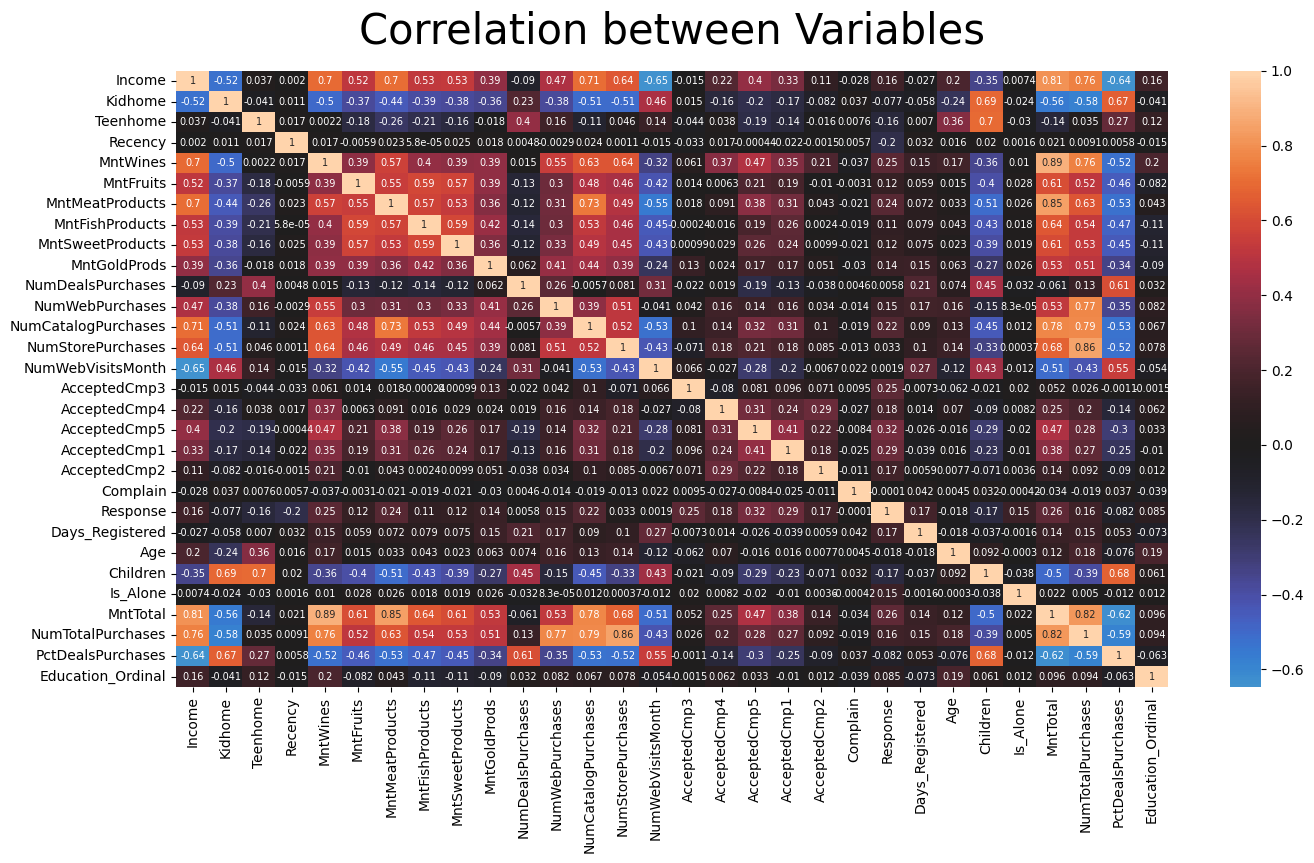

In [137]:
plt.figure(figsize=(16,8))
sns.heatmap(temp_df.corr(),annot=True, annot_kws={'size':7}, center=0)
plt.title('Correlation between Variables', size=30, pad=20)

In [139]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
temp_df2 = pd.DataFrame(standard_scaler.fit_transform(temp_df[['MntTotal', 'NumTotalPurchases']]), columns = ['MntTotal', 'NumTotalPurchases'])
                  
clusters = kmeans.fit_predict(temp_df2)

c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: xlabel='Income', ylabel='Age'>

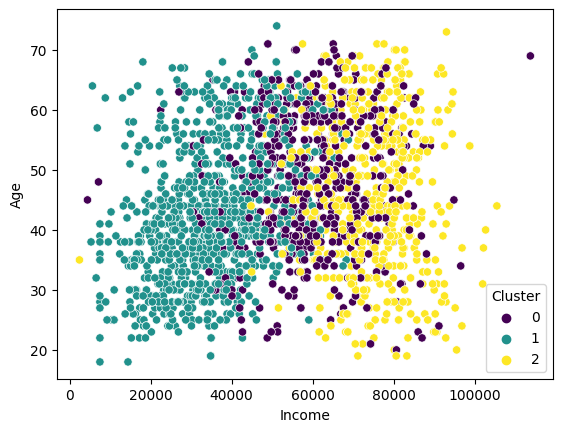

In [147]:
temp_df['Cluster'] = clusters
sns.scatterplot(data=temp_df[temp_df['Income']<120000], y='Age', x='Income', hue='Cluster', palette='viridis')

From this clustering, we can separate the customers into three groups: low-income, middle-income, and high-income groups. 

### Normal Clustering

In [99]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
temp_df = df.drop(['Education'], axis=1)
num_cols = temp_df.columns

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
temp_df = pd.DataFrame(standard_scaler.fit_transform(temp_df), columns = num_cols)
                  
clusters = kmeans.fit_predict(temp_df)

c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [100]:
temp_df

Income   Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0     0.291282 -0.824661 -0.931501  0.309822  0.973887   1.549895   
1    -0.264553  1.036959  0.905626 -0.381183 -0.874133  -0.638057   
2     0.926341 -0.824661 -0.931501 -0.795787  0.354919   0.569089   
3    -1.192894  1.036959 -0.931501 -0.795787 -0.874133  -0.562610   
4     0.298587  1.036959 -0.931501  1.553632 -0.394359   0.418196   
...        ...       ...       ...       ...       ...        ...   
2196  0.436674 -0.824661  0.905626 -0.104781  1.193044   0.418196   
2197  0.568210  2.898578  0.905626  0.240722  0.295688  -0.663206   
2198  0.236754 -0.824661 -0.931501  1.449981  1.782396   0.543940   
2199  0.814740 -0.824661  0.905626 -1.417691  0.360842   0.091260   
2200  0.042961  1.036959  0.905626 -0.312083 -0.657938  -0.587759   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  ...  \
0            1.686380         2.460103          1.479132      0.855494  ...   
1           -0.719559        -0.652586         -0.635442     -0.735878  ...   
2           -0.180450         1.343197         -0.149333     -0.037227  ...   
3           -0.657183        -0.506106         -0.586831     -0.755285  ...   
4           -0.220549         0.153051         -0.003501     -0.561215  ...   
...               ...              ...               ...           ...  ...   
2196         0.064599         0.079812          2.208295      3.941202  ...   
2197        -0.612628        -0.689206         -0.659748     -0.697064  ...   
2198         0.220539        -0.103288         -0.368082     -0.386552  ...   
2199         0.207173         0.775589          0.069416      0.331506  ...   
2200        -0.474510        -0.652586         -0.635442     -0.444773  ...   

      AcceptedCmp2  Complain  Response  Days_Registered       Age  Children  \
0        -0.117552 -0.095761  2.376878         1.975062  1.017794 -1.268522   
1        -0.117552 -0.095761 -0.420720        -1.669011  1.274330  1.401987   
2        -0.117552 -0.095761 -0.420720        -0.174338  0.333696 -1.268522   
3        -0.117552 -0.095761 -0.420720        -1.927456 -1.291036  0.066732   
4        -0.117552 -0.095761 -0.420720        -0.824757 -1.034500  0.066732   
...            ...       ...       ...              ...       ...       ...   
2196     -0.117552 -0.095761 -0.420720         0.122874  0.162671  0.066732   
2197     -0.117552 -0.095761 -0.420720        -1.944685  1.958428  2.737241   
2198     -0.117552 -0.095761 -0.420720        -0.850602 -1.034500 -1.268522   
2199     -0.117552 -0.095761 -0.420720        -0.846295  1.103306  0.066732   
2200     -0.117552 -0.095761  2.376878         1.160961  1.274330  1.401987   

      Is_Alone  MntTotal  NumTotalPurchases  PctDealsPurchases  
0     1.356466  1.672883           1.308164          -0.607209  
1     1.356466 -0.965195          -1.197000           1.504478  
2    -0.737210  0.277522           1.029812          -1.108735  
3    -0.737210 -0.922057          -0.918649           0.536622  
4    -0.737210 -0.309823           0.194758           0.674887  
...        ...       ...                ...                ...  
2196 -0.737210  1.214952           0.473109          -0.673199  
2197 -0.737210 -0.273322           0.333933           1.310907  
2198  1.356466  1.049035           0.751461          -1.076473  
2199 -0.737210  0.388686           1.168988          -0.846031  
2200 -0.737210 -0.724616          -0.640297           0.778586  

[2201 rows x 29 columns]

## Principal Component Analysis

In [111]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(temp_df)

In [112]:
pca.explained_variance_ratio_

array([3.21235659e-01, 9.02358280e-02, 6.71419409e-02, 5.53973632e-02,
       4.17556360e-02, 3.99846616e-02, 3.49685025e-02, 3.47801811e-02,
       3.45389882e-02, 2.99191289e-02, 2.79751545e-02, 2.60392776e-02,
       2.22311446e-02, 2.12513525e-02, 2.05163427e-02, 1.93863637e-02,
       1.75974010e-02, 1.71061835e-02, 1.47448131e-02, 1.43414185e-02,
       1.28573331e-02, 1.09210526e-02, 8.93608808e-03, 7.90961258e-03,
       5.66281783e-03, 2.56575495e-03, 6.33525631e-32, 3.36492866e-33,
       2.84841379e-33])

In [113]:
pd.DataFrame(X_pca)

0         1         2         3         4         5         6   \
0     4.528246  0.547758  0.389966  3.093211 -0.678537  0.889135  1.377480   
1    -3.375572  0.117526 -0.365491 -1.542346  2.037974  0.692162  0.999813   
2     2.375169 -0.574520 -1.268119 -0.165203 -1.114117  0.670807 -1.141070   
3    -2.946182 -1.728829 -0.010082 -0.196121  0.541779 -0.588335 -1.161810   
4    -0.624236  0.152966 -0.607617  0.673568  0.381615 -2.212978 -0.155201   
...        ...       ...       ...       ...       ...       ...       ...   
2196  2.667875  1.459554 -1.128186  0.824018 -0.277464  0.409530 -0.880352   
2197 -1.803241  3.596217  1.148084 -1.430044  3.303300 -1.641892 -0.584185   
2198  2.345531 -0.797111  0.714463 -1.603074 -2.325850 -0.975656  1.236138   
2199  2.165906  0.933083 -1.535294 -1.215718  0.520674  1.130345 -1.141006   
2200 -2.316884  1.468484  1.127217  0.273151  0.608514  0.673795 -0.089030   

            7         8         9   ...        19        20        21  \
0    -0.873913 -0.528251 -1.930791  ... -0.747505  0.607984  0.183431   
1    -0.895400 -0.473234 -0.108568  ... -0.178035 -0.076365 -0.078302   
2    -0.087901  0.795059  0.573560  ...  0.405926  0.860581  0.591894   
3    -0.392814  0.531931  1.365502  ... -0.047491  0.182378 -0.366593   
4     0.279533 -0.505300  0.919118  ...  0.069932  0.077281  0.505795   
...        ...       ...       ...  ...       ...       ...       ...   
2196  0.999640 -0.319092  0.152135  ... -0.110179 -1.126699 -1.000792   
2197 -0.024125  0.130305 -0.283238  ...  0.171216 -0.751829  0.336577   
2198 -0.756693 -1.145673  1.805453  ...  0.203976 -0.100374 -1.448286   
2199 -0.211810  0.955981  0.368416  ...  0.368452  0.405123  0.145076   
2200 -0.312274  0.676831 -2.019758  ...  0.781432 -0.073576 -0.029878   

            22        23        24        25            26            27  \
0    -0.912384 -0.375704  0.138262  0.087627 -3.213625e-14  3.487153e-16   
1    -0.083812 -0.116647 -0.007896 -0.534990  1.369169e-14  5.066908e-15   
2     0.476782 -0.241845 -0.293850 -0.377093  3.536947e-14  8.448527e-15   
3    -0.206410  0.045713  0.196711  0.095773 -3.728801e-16  5.373298e-17   
4     0.093341 -0.463634 -0.520873  0.088675 -6.785008e-15  4.636665e-15   
...        ...       ...       ...       ...           ...           ...   
2196  0.642863 -0.667999  0.445991 -0.021990 -5.037090e-17 -3.307766e-17   
2197  0.311235 -0.420586 -0.329211  0.506580 -2.205301e-16 -6.351815e-17   
2198 -0.550469  0.270753 -0.183809 -0.012198 -3.524421e-16 -3.186127e-17   
2199 -0.378946  0.129710  0.129921 -0.054925 -2.732309e-16  4.569658e-17   
2200  0.016378  0.099769 -0.365979 -0.064524 -2.792267e-16  4.378939e-17   

                28  
0     1.009121e-14  
1     2.024770e-15  
2     4.512364e-15  
3    -1.898009e-16  
4    -5.903089e-15  
...            ...  
2196  6.440210e-17  
2197  4.113926e-17  
2198  7.411218e-17  
2199  3.923288e-17  
2200 -4.124286e-17  

[2201 rows x 29 columns]

In [114]:
loadings = pd.DataFrame(pca.components_.T,
                        index=num_cols)
loadings

0         1         2         3         4   \
Income               0.278885  0.075576 -0.044065 -0.154296  0.170999   
Kidhome             -0.225814  0.029454  0.121494  0.168611  0.289475   
Teenhome            -0.060384  0.458298 -0.123081 -0.266639  0.177650   
Recency              0.001213  0.023019 -0.108452 -0.066306 -0.149706   
MntWines             0.260633  0.163612  0.168657 -0.093259 -0.091529   
MntFruits            0.217320 -0.058119 -0.146107  0.192725  0.132224   
MntMeatProducts      0.263588 -0.066721 -0.006855  0.098175  0.157012   
MntFishProducts      0.226179 -0.066038 -0.142875  0.184137  0.121397   
MntSweetProducts     0.219611 -0.046310 -0.118270  0.160087  0.128067   
MntGoldProds         0.180287  0.112344 -0.039294  0.219296  0.003499   
NumDealsPurchases   -0.056261  0.480392  0.033300  0.211189  0.093858   
NumWebPurchases      0.182596  0.319406  0.002790  0.095345 -0.184745   
NumCatalogPurchases  0.267014  0.048242 -0.003183  0.049661  0.121781   
NumStorePurchases    0.242125  0.174607 -0.123597 -0.045010 -0.119254   
NumWebVisitsMonth   -0.204705  0.182265  0.208629  0.228473 -0.286859   
AcceptedCmp3         0.013984 -0.017426  0.233219  0.224202  0.285208   
AcceptedCmp4         0.077957  0.095571  0.358655 -0.334613 -0.235879   
AcceptedCmp5         0.153014 -0.091448  0.365556 -0.149701  0.133297   
AcceptedCmp1         0.134395 -0.063326  0.326079 -0.085495  0.219172   
AcceptedCmp2         0.046124  0.016696  0.359929 -0.217562 -0.135163   
Complain            -0.012026  0.010255 -0.005407  0.055053  0.005371   
Response             0.083573 -0.008319  0.460576  0.204781  0.139276   
Days_Registered      0.028063  0.179445  0.105573  0.398001 -0.435534   
Age                  0.045426  0.226816 -0.124807 -0.338772  0.073090   
Children            -0.205854  0.354224 -0.002315 -0.072861  0.336746   
Is_Alone             0.008847 -0.027059  0.058942  0.082060  0.035720   
MntTotal             0.309411  0.063439  0.057915  0.043389  0.035958   
NumTotalPurchases    0.287519  0.220097 -0.055996  0.036236 -0.074595   
PctDealsPurchases   -0.249027  0.213803  0.096389  0.161627  0.200006   

                           5         6         7         8         9   ...  \
Income              -0.039890  0.023349 -0.041695  0.026896  0.020550  ...   
Kidhome             -0.314129  0.024597 -0.090358  0.005995  0.092449  ...   
Teenhome             0.146419  0.030173  0.057883 -0.015489 -0.055381  ...   
Recency             -0.457602  0.396625  0.445413 -0.506704 -0.148272  ...   
MntWines            -0.039904 -0.009136  0.019215 -0.009126  0.034194  ...   
MntFruits           -0.071579  0.034035 -0.073137  0.026857 -0.001914  ...   
MntMeatProducts     -0.138427  0.065250 -0.074103  0.015320 -0.116278  ...   
MntFishProducts     -0.090088  0.018964 -0.066802  0.009851 -0.085975  ...   
MntSweetProducts    -0.129052  0.032116 -0.071658  0.002264 -0.057998  ...   
MntGoldProds         0.100267 -0.060720  0.182152 -0.147890  0.080658  ...   
NumDealsPurchases   -0.172798 -0.030017 -0.127672  0.001126  0.085357  ...   
NumWebPurchases      0.105688 -0.109102  0.047670 -0.007834  0.199874  ...   
NumCatalogPurchases -0.022349  0.026067  0.054320 -0.024488 -0.044715  ...   
NumStorePurchases   -0.033727 -0.040276 -0.070018  0.051931  0.239572  ...   
NumWebVisitsMonth    0.023432 -0.055606  0.044176 -0.014241 -0.021170  ...   
AcceptedCmp3         0.352551 -0.107528  0.583853 -0.209670  0.148896  ...   
AcceptedCmp4        -0.162486  0.051770 -0.165646  0.016420  0.067570  ...   
AcceptedCmp5        -0.184784  0.020279  0.022557  0.044678 -0.105456  ...   
AcceptedCmp1        -0.128434 -0.034168  0.016618  0.017423 -0.194630  ...   
AcceptedCmp2        -0.048860  0.017366  0.117151 -0.072322  0.277823  ...   
Complain            -0.010662  0.579786  0.335511  0.706765  0.185801  ...   
Response             0.268010  0.066696 -0.125680  0.053402 -0.214272  ...   
Days_Registered     -0.031135  0.097271 -0

<AxesSubplot: >

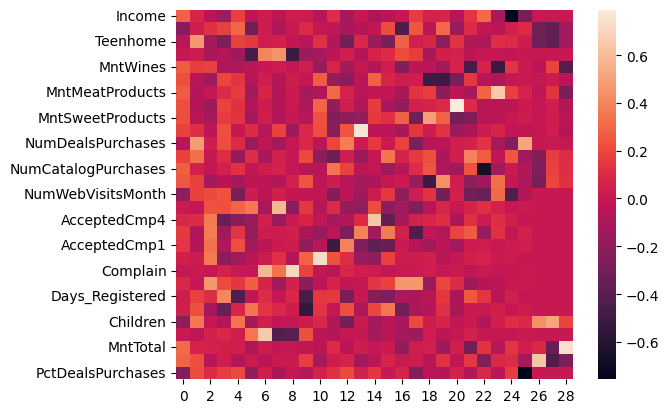

In [115]:
sns.heatmap(loadings)

Text(0.5, 1.0, 'Principal Component Analysis')

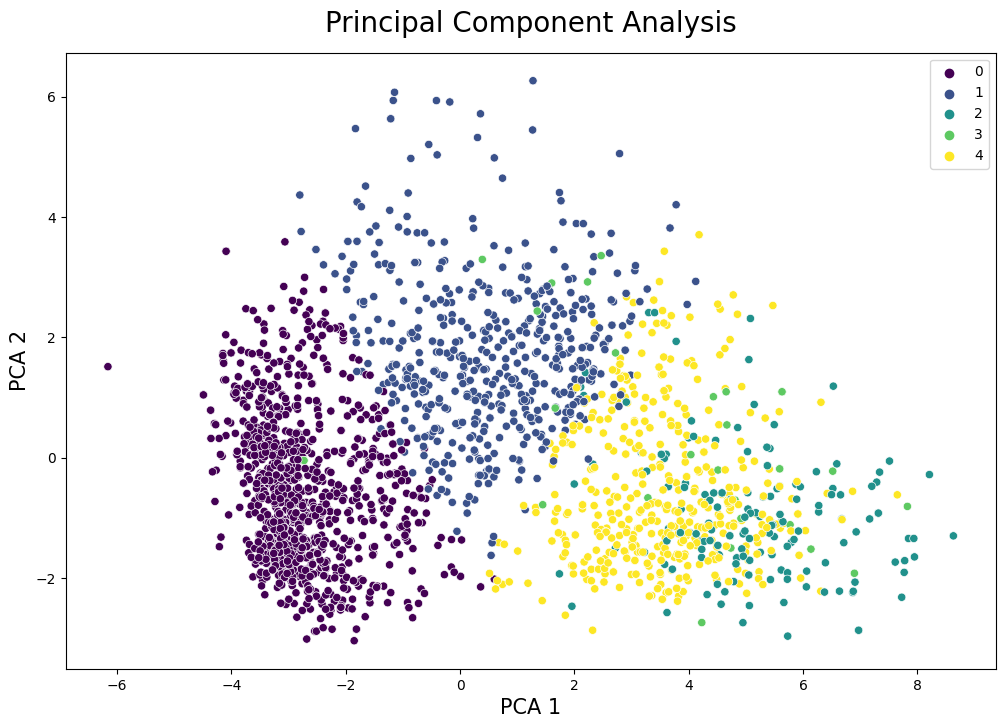

In [129]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                hue=clusters, 
                palette='viridis'
                )
# plt.xlim(0,200000)
# plt.ylim(0,80)
plt.xlabel('PCA 1',size=15)
plt.ylabel('PCA 2', size=15)
plt.title('Principal Component Analysis',size=20,pad=15)